# Predict locations: A strange spatial idea

Given a waterbody time series, predict its x and y coordinates. This is roughly possible thanks to climate and regulations, but how accurate could it be?

Using a SAD curve as input, construct a CNN that predicts the x and y.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import autograd

import sys

In [2]:
wbs = gpd.read_file('waterbodies_joined_drainage_basins.shp')

In [3]:
history = h5py.File('interpolated_waterbodies_by_division_and_basin_fixed.h5', 'r')

Construct downsampled SAD curves.

In [4]:
sads = []
uids = []
for div in tqdm(history, position=0):
    if div == 'dates':
        continue
    for basin in tqdm(history[div], position=1, leave=False):
        sad = np.sort(history[div][basin]['pc_wet'], axis=1)[:, ::-1]
        downsad = sad[:, ::10]  # 10x smaller. Roughly accurate even without smoothing since there's so much data and we've sorted.
        sads.append(downsad)
        uids.append(history[div][basin]['uid'][()])

In [5]:
sads = np.concatenate(sads)

In [6]:
uids = np.concatenate(uids)

In [7]:
len(uids), len(sads)

(292977, 292977)

In [8]:
uids = [u.decode('ascii') for u in uids]

Get coordinates.

In [9]:
assert len(set(uids)) == len(uids)

In [10]:
ordered_wbs = wbs.set_index('UID').loc[uids]
coords = np.stack([ordered_wbs.centroid.x, ordered_wbs.centroid.y]).T

In [11]:
assert list(ordered_wbs.index) == uids

Construct a PyTorch dataloader for handling our training data.

In [12]:
X = np.nan_to_num(sads[:, None, :]).astype('float32')

In [13]:
X -= X.mean()

In [14]:
X /= X.std()

In [15]:
coords -= coords.min(axis=0, keepdims=True)
coords /= coords.max(axis=0, keepdims=True)

In [34]:
polsbypopper = ordered_wbs.area / (ordered_wbs.boundary.length ** 2)

In [35]:
polsbypopper -= polsbypopper.mean()
polsbypopper /= polsbypopper.std()

In [40]:
dataloader = DataLoader(
    TensorDataset(torch.Tensor(X), torch.Tensor(polsbypopper.values[:, None])),
    batch_size=16)

Build a convnet.

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool1d(2)
        self.conv1 = nn.Conv1d(1, 4, 5)
        self.conv2 = nn.Conv1d(4, 16, 5)
        self.fc1 = nn.Linear(16 * 152, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 152)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [47]:
criterion = nn.MSELoss()
optimiser = optim.SGD(net.parameters(), lr=1e-2)

In [54]:
for epoch in tqdm(range(2), position=0):
    running_loss = 0.0
    bar = tqdm(total=len(dataloader), position=1)
    for i, data in enumerate(dataloader):
        inputs, labels = data

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + backward + optimize
#         with autograd.detect_anomaly():
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        # print statistics
        running_loss += loss.item()
        bar.postfix = ' {:.2e}'.format(running_loss / (i + 1))
        bar.update(1)

print('Finished training')


Finished training


In [55]:
predictions = net(torch.Tensor(X[:10000]))

In [56]:
# fig, (axl, axr) = plt.subplots(1, 2, figsize=(10, 5))
# axl.scatter(coords[:100000:2, 0], coords[:100000:2, 1], c=predictions.detach()[::2, 0], s=1,
#             edgecolor='None', cmap='rainbow', vmin=0, vmax=1)
# axr.scatter(coords[:100000:2, 0], coords[:100000:2, 1], c=predictions.detach()[::2, 1], s=1,
#             edgecolor='None', cmap='rainbow', vmin=0, vmax=1)

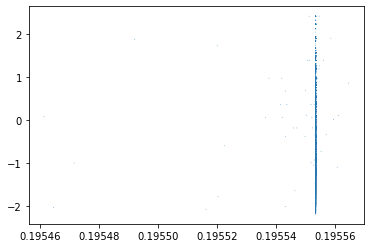

In [57]:
plt.scatter(predictions.detach()[:, 0], polsbypopper[:10000], s=1, alpha=0.5, edgecolor='None')

In [46]:
(predictions == 0).all()

tensor(False)

In [47]:
predictions

tensor([[0.7915, 0.0530],
        [0.7892, 0.0486],
        [0.7896, 0.0499],
        ...,
        [0.7911, 0.0488],
        [0.7971, 0.0466],
        [0.7907, 0.0525]], grad_fn=<AddmmBackward>)